# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

# Overview

The data provided for this project is for a music streaming service named sparkify. The data is the user log of the service, having info like  user pages accessed, timestamps, songs listened . 

Our task is to analyze the data and build a model which can identify users who are highly likely to move away from the service(churn). These insights cna then be used  to devise retention strategies for churning users.

We will clean the data, and explore the data aided with visualizations to see the trends which can highlight features to segregate churning and non-churning users. 





# Strategy

We will use pyspark to work with this problem as the original dataset here are of large size 12G. One of the drving force to us e pyspark is that the project aims at building the ability to efficiently manipulate large datasets with Spark.

The ideal platform is to use AWS/IBM cloud spark cluster. However in the interest of time and money I ahve focussed to use this workspace here and then leverage the workbook to use in spark cluster later on. 

For this workspace we are going to use subset of the original data provided:

mini_sparkify_event_data.json





# Metric

We will use F1 score here as we have an unbalanced data set and we have to keep a check on both false postive and false negative as both can impact revenue.

In [1]:
# import libraries
#!conda remove -y numpy
#!conda install -y -c anaconda numpy
#!conda install -y  -c anaconda matplotlib
#!conda install -y  -c anaconda seaborn=0.9.0

import numpy as np
from pyspark.sql import SparkSession
import pyspark.sql.functions as sf
import pyspark.sql.types as st
from pyspark.sql.functions import col, lit, udf, isnan, count, when, desc, sort_array, asc, avg, lag, floor

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from pyspark.sql.types import IntegerType, DateType

from pyspark.sql.functions import sum as Fsum
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer, MinMaxScaler #used because won't distort binary vars
from pyspark.sql.types import DoubleType
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import datetime

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, GBTClassifier
import time



In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Identify Features") \
    .getOrCreate()

df = spark.read.json('mini_sparkify_event_data.json')
df.persist()
df.show(3)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|             song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|        Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   

In [3]:
df.count()

286500

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
df_nulls = df.select([sf.count(sf.when(sf.isnull(c), c)).alias(c) for c in df.columns])
df_nulls.show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [6]:
df.filter(df.registration.isNull()).select("userId").distinct().show()

+------+
|userId|
+------+
|      |
+------+



In [7]:
df.filter(df.registration.isNull()).show(3)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET|Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET|Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET|Home|        null|        8|null|   200|1538355841000|     null|      |
+------+----------+---------+------+----

In [8]:
df.filter(df.userId == "").show(3)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET|Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET|Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET|Home|        null|        8|null|   200|1538355841000|     null|      |
+------+----------+---------+------+----

In [9]:
df.filter(df.userId == "").count()

8346

It seems that the daat where user id is blank , we also get null registration value.We can discard these values.

In [10]:
df = df.filter(df.userId != "")
df.count()

278154

In [11]:
df = df.dropna(how ="any", subset =["userId", "sessionId"])
df.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.



In [12]:
df.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [13]:
distinct_pages = df.select('page').distinct().collect()
distinct_pages

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Settings'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [14]:
distinct_pages = [row['page'] for row in distinct_pages]
distinct_pages

['Cancel',
 'Submit Downgrade',
 'Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'Cancellation Confirmation',
 'About',
 'Settings',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade']

In [15]:
df.select("userId").distinct().count()

225

In [16]:
df.filter(df.page=="Cancellation Confirmation").select("userId").distinct().count()

52

In [17]:
df.agg(sf.countDistinct('userId'), sf.countDistinct('sessionId')).show()

+----------------------+-------------------------+
|count(DISTINCT userId)|count(DISTINCT sessionId)|
+----------------------+-------------------------+
|                   225|                     2312|
+----------------------+-------------------------+



In [18]:
event_counts = df.groupby('page').count().sort('count', ascending=False).toPandas().set_index('page')
event_counts

,count
page,
NextSong,228108
Thumbs Up,12551
Home,10082
Add to Playlist,6526
Add Friend,4277
Roll Advert,3933
Logout,3226
Thumbs Down,2546
Downgrade,2055


As expected the NextSong page is the most frequent and the Downgrade, Cancellation Confirmation,Register pages happen less frequently.

In [19]:
df.filter(df.page=="Cancellation Confirmation").select("level").distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [20]:
def convert_ms(x):
    """Converts given ns to ms"""
    if x is None:
        return None
    
    return x//1000

convert_ms_udf = sf.udf(convert_ms, st.LongType())

df = df.withColumn('timestamp', convert_ms_udf(df.ts).cast('timestamp'))
df = df.withColumn('registration_ts', convert_ms_udf(df.registration).cast('timestamp'))

df.select('ts', 'timestamp', 'registration', 'registration_ts').show(5)

+-------------+-------------------+-------------+-------------------+
|           ts|          timestamp| registration|    registration_ts|
+-------------+-------------------+-------------+-------------------+
|1538352117000|2018-10-01 00:01:57|1538173362000|2018-09-28 22:22:42|
|1538352180000|2018-10-01 00:03:00|1538331630000|2018-09-30 18:20:30|
|1538352394000|2018-10-01 00:06:34|1538173362000|2018-09-28 22:22:42|
|1538352416000|2018-10-01 00:06:56|1538331630000|2018-09-30 18:20:30|
|1538352676000|2018-10-01 00:11:16|1538173362000|2018-09-28 22:22:42|
+-------------+-------------------+-------------+-------------------+
only showing top 5 rows



In [21]:
df.where(df.page=='Cancellation Confirmation').show(5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-------------------+-------------------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|          timestamp|    registration_ts|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-------------------+-------------------+
|  null|Cancelled|   Adriel|     M|          104| Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|2018-10-07 20:26:30|2018-08-30 10:04:26|
|  null|Cancelled|    Diego|     M|         

In [22]:
df.agg(sf.min('timestamp'), sf.max('timestamp')).show()
df.agg(sf.min('registration_ts'), sf.max('registration_ts')).show()

+-------------------+-------------------+
|     min(timestamp)|     max(timestamp)|
+-------------------+-------------------+
|2018-10-01 00:01:57|2018-12-03 01:11:16|
+-------------------+-------------------+

+--------------------+--------------------+
|min(registration_ts)|max(registration_ts)|
+--------------------+--------------------+
| 2018-03-18 13:44:35| 2018-11-26 15:49:14|
+--------------------+--------------------+



In [23]:
def plot_value_count(df, column, page=None):
    """
    Plots the distribution of a given column
    
    Arguments:
        df : input dataframe
        column : The column to plot the distribution 
        page (str): Optional, limits the distribution to a single page
    """
    if page is not None:
        plot_df = df.where(df.page==page)
    else:
        plot_df = df
    
    values = plot_df.groupby(column).count().toPandas()
    
    sns.distplot(values['count'], 
                 kde=False, 
                 bins=20)
    


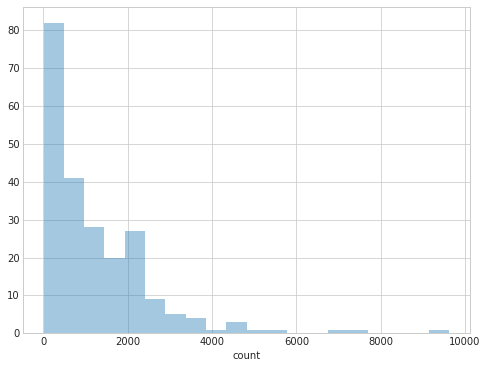

In [24]:
plt.figure(figsize=(8,6))
plot_value_count(df, 'userId')

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [25]:
df.where(df.page=='Cancellation Confirmation').select(['page', 'timestamp', 'userId', 'sessionId', 'level', 'registration_ts']).show(10)

+--------------------+-------------------+------+---------+-----+-------------------+
|                page|          timestamp|userId|sessionId|level|    registration_ts|
+--------------------+-------------------+------+---------+-----+-------------------+
|Cancellation Conf...|2018-10-07 20:26:30|    18|      514| paid|2018-08-30 10:04:26|
|Cancellation Conf...|2018-10-08 21:10:46|    32|      540| paid|2018-09-17 06:59:53|
|Cancellation Conf...|2018-10-12 04:35:18|   125|      174| free|2018-08-01 20:58:59|
|Cancellation Conf...|2018-10-12 20:17:21|   105|      508| paid|2018-09-13 05:43:01|
|Cancellation Conf...|2018-10-13 21:19:44|    17|      797| paid|2018-09-30 18:57:09|
|Cancellation Conf...|2018-10-15 07:34:14|   143|      843| free|2018-08-14 13:58:33|
|Cancellation Conf...|2018-10-16 22:30:37|   101|      842| paid|2018-08-23 23:19:40|
|Cancellation Conf...|2018-10-17 00:29:21|   129|      802| paid|2018-09-30 06:42:56|
|Cancellation Conf...|2018-10-17 07:02:29|   121|     

In [26]:
df.where((df.userId==32) &
         (df.timestamp>'2018-10-08 19:10:46')).sort('ts').select('timestamp', 'page','sessionId', 'level', 'registration_ts').show(100)

+-------------------+--------------------+---------+-----+-------------------+
|          timestamp|                page|sessionId|level|    registration_ts|
+-------------------+--------------------+---------+-----+-------------------+
|2018-10-08 19:13:53|            NextSong|      540| paid|2018-09-17 06:59:53|
|2018-10-08 19:16:54|            NextSong|      540| paid|2018-09-17 06:59:53|
|2018-10-08 19:21:23|            NextSong|      540| paid|2018-09-17 06:59:53|
|2018-10-08 19:24:48|            NextSong|      540| paid|2018-09-17 06:59:53|
|2018-10-08 19:28:26|            NextSong|      540| paid|2018-09-17 06:59:53|
|2018-10-08 19:33:22|            NextSong|      540| paid|2018-09-17 06:59:53|
|2018-10-08 19:37:28|            NextSong|      540| paid|2018-09-17 06:59:53|
|2018-10-08 19:40:52|            NextSong|      540| paid|2018-09-17 06:59:53|
|2018-10-08 19:46:49|            NextSong|      540| paid|2018-09-17 06:59:53|
|2018-10-08 19:52:31|            NextSong|      540|

In [27]:
churn_users = df.where(df.page=='Cancellation Confirmation').select('userId').toPandas().userId.tolist()

df = df.withColumn('churn', df.userId.isin(churn_users))
df.select('page', 'timestamp', 'userId', 'sessionId', 'level', 'churn').show(5)

+--------+-------------------+------+---------+-----+-----+
|    page|          timestamp|userId|sessionId|level|churn|
+--------+-------------------+------+---------+-----+-----+
|NextSong|2018-10-01 00:01:57|    30|       29| paid|false|
|NextSong|2018-10-01 00:03:00|     9|        8| free|false|
|NextSong|2018-10-01 00:06:34|    30|       29| paid|false|
|NextSong|2018-10-01 00:06:56|     9|        8| free|false|
|NextSong|2018-10-01 00:11:16|    30|       29| paid|false|
+--------+-------------------+------+---------+-----+-----+
only showing top 5 rows



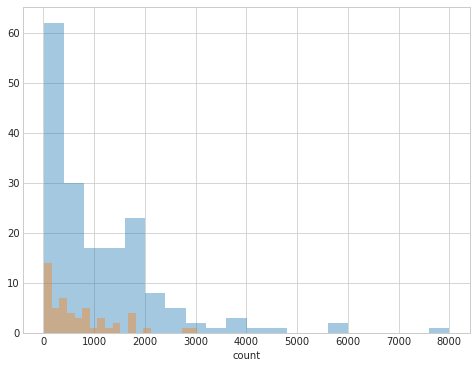

In [28]:
plt.figure(figsize=(8, 6))
plot_value_count(df.where(~df.churn), 'userId', page='NextSong')
plot_value_count(df.where(df.churn), 'userId', page='NextSong')

We can see clearly that churn users do not go through lot of songs as compared to other users.

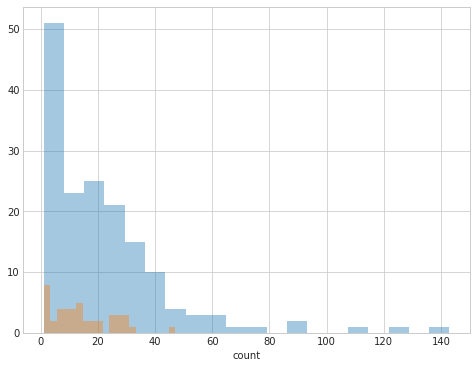

In [29]:
plt.figure(figsize=(8, 6))
plot_value_count(df.where(~df.churn), 'userId', page='Add Friend')
plot_value_count(df.where(df.churn), 'userId', page='Add Friend')

We see a remarkable difference between users who churn out and others.The churn users tend to add way more friends, giving a hint of user traits who might churn away.

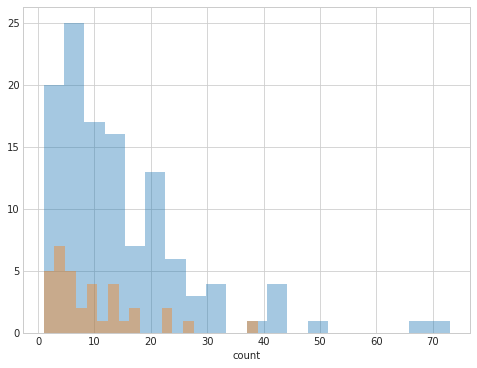

In [30]:
plt.figure(figsize=(8, 6))
plot_value_count(df.where(~df.churn), 'userId', page='Downgrade')
plot_value_count(df.where(df.churn), 'userId', page='Downgrade')

More number of downgrades suggest user is likely to stay, which is indicative of the fact that user engagement is on.

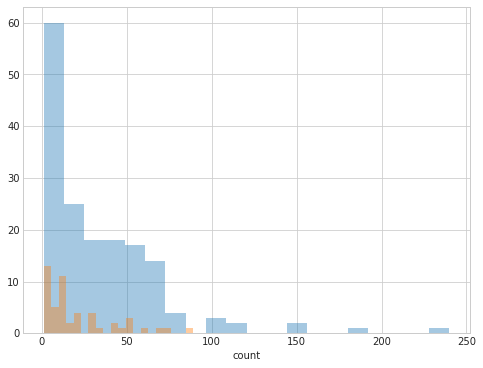

In [31]:

plt.figure(figsize=(8, 6))
plot_value_count(df.where(~df.churn), 'userId', page='Add to Playlist')
plot_value_count(df.where(df.churn), 'userId', page='Add to Playlist')

More playlists suggest thaht users are going to continue.

,churn,gender,count
0,False,M,89
1,False,F,84
2,True,F,20
3,True,M,32


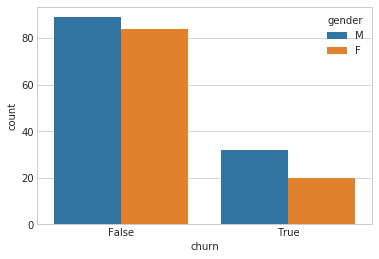

In [32]:
df_pd = df.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
display(df_pd.head())
sns.barplot(x='churn', y='count', hue='gender', data=df_pd)

Male users tend to churn more than female users.

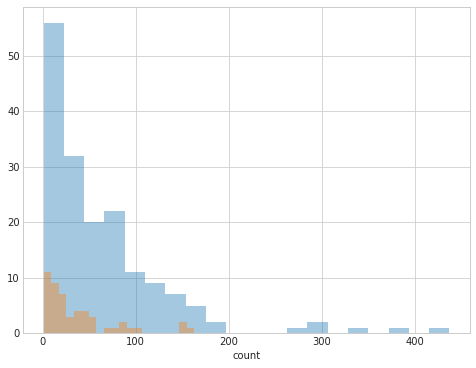

In [33]:

plt.figure(figsize=(8, 6))
plot_value_count(df.where(~df.churn), 'userId', page='Thumbs Up')
plot_value_count(df.where(df.churn), 'userId', page='Thumbs Up')

More thumbs up suggest users are happy and engaged and less churn.

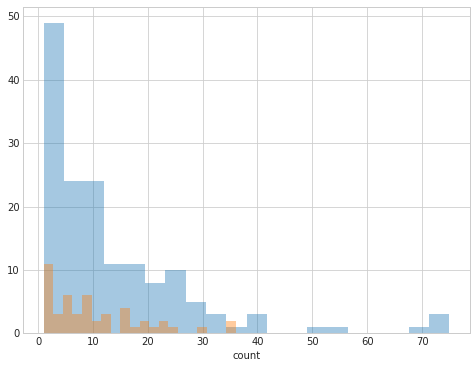

In [34]:
plt.figure(figsize=(8, 6))
plot_value_count(df.where(~df.churn), 'userId', page='Thumbs Down')
plot_value_count(df.where(df.churn), 'userId', page='Thumbs Down')

Surprisingly churn user doesn't have large thumbs down as i was expecting. Maybe it again the engagement factor playing a role here.

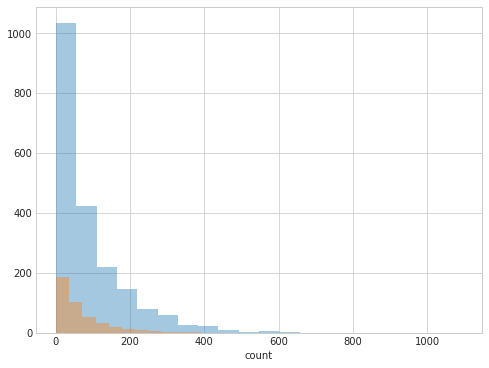

In [35]:
plt.figure(figsize=(8, 6))
plot_value_count(df.where(~df.churn), 'sessionId', page='NextSong')
plot_value_count(df.where(df.churn), 'sessionId', page='NextSong')

Non churn users tend to listen songs for long in a session.

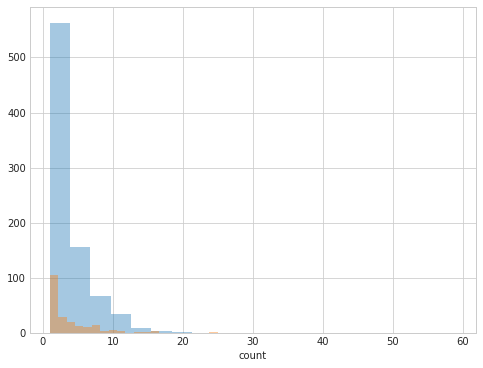

In [36]:
plt.figure(figsize=(8, 6))
plot_value_count(df.where(~df.churn), 'sessionId', page='Roll Advert')
plot_value_count(df.where(df.churn), 'sessionId', page='Roll Advert')

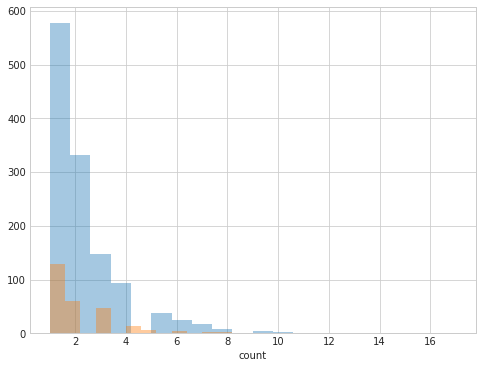

In [37]:
plt.figure(figsize=(8, 6))
plot_value_count(df.where(~df.churn), 'sessionId', page='Logout')
plot_value_count(df.where(df.churn), 'sessionId', page='Logout')

more number of songs played by non-churn users as exepcted.

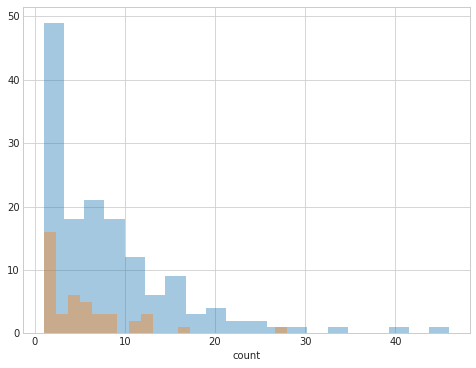

In [38]:
plt.figure(figsize=(8, 6))
plot_value_count(df.where(~df.churn), 'userId', page='Help')
plot_value_count(df.where(df.churn), 'userId', page='Help')

More help pages suggest users are trying to engage more and hence less churn.

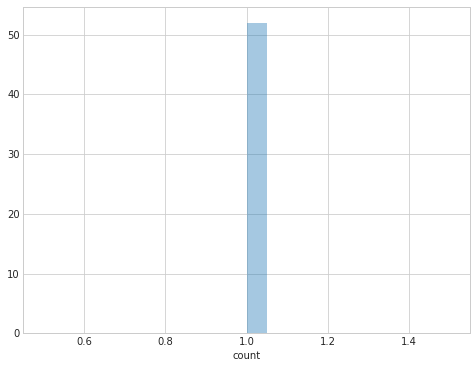

In [39]:
plt.figure(figsize=(8, 6))
#no_churn_song_counts = plot_field_count_dist(df.where(~df.churn), 'userId', page='Cancel')
plot_value_count(df.where(df.churn), 'userId', page='Cancel')

Cancel page was used only churn users.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary



Except for Cancel, most of the page entries seems useful, so i will try to keep the maximum of the lot in my features.Will try to see the impact of downgrade features on the final result. 

In [5]:
def build_features(df):
    """
    Build the feature set for given dataframe.
    
    Arguments:
        df : input dataframe

    """
    df = df.filter(df.userId != "")
    df = df.dropna(how ="any", subset =["userId", "sessionId"])
    
    distinct_pages = df.select('page').distinct().collect()
    distinct_pages = [row['page'] for row in distinct_pages]
    
    features = df.groupby('userId').pivot('page', distinct_pages).count().sort('userId')
    
    
    # As i was gettting accuracy and F1-score of 1, I am trying to remove Cancel page as feature
    features = features.drop('Cancel')
    features = features.drop('Downgrade')
    features = features.drop('Submit Downgrade')

    
    features = features.fillna(0)
    features = features.withColumnRenamed('Cancellation Confirmation', 'churn')
    
    songsPlayed = df.where(col('song')!='null').groupby("userId").agg(count(col('song')).alias('SongsPlayed')).sort('userId')
    features = features.join(songsPlayed, on='userId')
    
    session_counts = df.groupby('userId').agg(sf.countDistinct('sessionId').alias('session_count')).sort('userId')
    features = features.join(session_counts, on='userId')
    
    genders = df.select('userId', sf.when(sf.col('gender')=='F', 0).otherwise(1).alias('genders')).distinct().sort('userId')
    features = features.join(genders, on='userId')
    
    return features

    
    
    
    
    
    
    

In [6]:
temp_df = spark.read.json('mini_sparkify_event_data.json')


In [7]:
outputFeatures = build_features(temp_df)
outputFeatures.show(3)

+------+----------------+-----------+----+---------+-----------+------+-------------+-----+-----+--------+---------------+----------+--------+---------+----+-------+-----+--------------+-----------+-------------+-------+
|userId|Submit Downgrade|Thumbs Down|Home|Downgrade|Roll Advert|Logout|Save Settings|churn|About|Settings|Add to Playlist|Add Friend|NextSong|Thumbs Up|Help|Upgrade|Error|Submit Upgrade|SongsPlayed|session_count|genders|
+------+----------------+-----------+----+---------+-----------+------+-------------+-----+-----+--------+---------------+----------+--------+---------+----+-------+-----+--------------+-----------+-------------+-------+
|    10|               0|          4|  30|        7|          1|    11|            1|    0|    2|       7|              9|        12|     673|       37|   1|      0|    0|             0|        673|            6|      1|
|   100|               1|         27| 105|       30|         25|    35|            5|    0|   12|      11|          

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Implementation

split datest into train, validation and test sets.

train model using training dataset.We will try LogisticRegression RandomForestClassifier  GBTClassifier models.

tune model.

Pick best model selected based on validation dataset.

In [8]:
feature_cols = outputFeatures.drop('userId', 'churn').columns

"""
feature_cols = ['Thumbs Down',
 'Roll Advert',
 'Save Settings',
 'Settings',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Error',
 'SongsPlayed',
 'session_count',
]
"""


outputFeatures = outputFeatures.withColumn("label", outputFeatures["churn"].cast('integer'))
assembler = VectorAssembler(inputCols=feature_cols,\
                            outputCol="features")

X = assembler.transform(outputFeatures)['features','label']


train, rest = X.randomSplit([0.6, 0.4])
test, validation = X.randomSplit([0.5, 0.5])

scaler = MinMaxScaler(inputCol="features", outputCol="ScaledFeatures")
scaler = scaler.fit(train)


train = scaler.transform(train)['ScaledFeatures','label']
test = scaler.transform(test)['ScaledFeatures','label']
validation = scaler.transform(validation)['ScaledFeatures','label']

#scaler = Normalizer()

train.show()

+--------------------+-----+
|      ScaledFeatures|label|
+--------------------+-----+
|[0.33333333333333...|    0|
|[0.0,0.0666666666...|    0|
|[0.0,0.04,0.02631...|    1|
|[0.33333333333333...|    1|
|[0.33333333333333...|    0|
|[0.0,0.0133333333...|    1|
|[0.0,0.0133333333...|    1|
|[0.0,0.0266666666...|    1|
|[0.0,0.0,0.003759...|    1|
|[0.33333333333333...|    1|
|[0.33333333333333...|    1|
|[0.0,0.2266666666...|    0|
|[0.0,0.08,0.13157...|    1|
|[0.0,0.08,0.10902...|    0|
|[0.33333333333333...|    0|
|[0.0,0.0266666666...|    0|
|[0.0,0.08,0.09022...|    0|
|[0.0,0.04,0.06015...|    0|
|[0.0,0.16,0.27067...|    0|
|[0.0,0.16,0.24812...|    0|
+--------------------+-----+
only showing top 20 rows



In [23]:
x = train.toPandas().iloc[0]['ScaledFeatures']

In [24]:
len(x), len(feature_cols)

(20, 20)

In [28]:
model_lr = LogisticRegression(featuresCol="ScaledFeatures", labelCol="label", maxIter=10, regParam=0.01)
model_rf = RandomForestClassifier(featuresCol="ScaledFeatures", labelCol="label")
model_gbt = GBTClassifier(featuresCol="ScaledFeatures", labelCol="label")

In [29]:
#Fit the model
import time

start_time= time.time()

model_lr = model_lr.fit(train)
model_rf = model_rf.fit(train)
model_gbt = model_gbt.fit(train)

end_time= time.time()

print("Total time:{}".format(end_time-start_time))

Total time:545.8355071544647


In [11]:
def model_performance(model, test_data, metric = 'accuracy'):
    """ Calculate Model Scores using f1 metric 
        Input: 
            model- trained model or pipeline object
            metric- the metric used to measure performance
            data - data on which performance measurement should be done
        Output:
            score
    """
    evaluator = MulticlassClassificationEvaluator(metricName = metric)
    prediction_result = model.transform(test_data)
    # find f1 score
    score = evaluator.evaluate(prediction_result)
    #return score
    return score

In [30]:
#Accuracy score
print("Logistic Regression Classifier Accuracy:{}".format(model_performance(model_lr, test)))
print("Random Forest  Classifier Accuracy:{}".format(model_performance(model_rf, test)))
print("GBTClassifier  Classifier Accuracy:{}".format(model_performance(model_gbt, test)))

#Validation set
print("Logistic Regression Classifier Accuracy:{}".format(model_performance(model_lr, validation)))
print("Random Forest  Classifier Accuracy:{}".format(model_performance(model_rf, validation)))
print("GBTClassifier  Classifier Accuracy:{}".format(model_performance(model_gbt, validation)))

Logistic Regression Classifier Accuracy:0.75
Random Forest  Classifier Accuracy:0.8275862068965517
GBTClassifier  Classifier Accuracy:0.8793103448275862
Logistic Regression Classifier Accuracy:0.7798165137614679
Random Forest  Classifier Accuracy:0.8715596330275229
GBTClassifier  Classifier Accuracy:0.8532110091743119


In [31]:
#F1-Score
print("Logistic Regression Classifier F1-Score:{}".format(model_performance(model_lr, test, 'f1')))
print("Random Forest  Classifier F1-Score:{}".format(model_performance(model_rf, test, 'f1')))
print("GBTClassifier  Classifier F1-Score:{}".format(model_performance(model_gbt, test, 'f1')))

#Validation set
print("Logistic Regression Classifier F1-Score:{}".format(model_performance(model_lr, validation, 'f1')))
print("Random Forest  Classifier F1-Score:{}".format(model_performance(model_rf, validation, 'f1')))
print("GBTClassifier  Classifier F1-Score:{}".format(model_performance(model_gbt, validation, 'f1')))

Logistic Regression Classifier F1-Score:0.67100654789097
Random Forest  Classifier F1-Score:0.791101465002713
GBTClassifier  Classifier F1-Score:0.8700181159420288
Logistic Regression Classifier F1-Score:0.7065984474241355
Random Forest  Classifier F1-Score:0.848297080003946
GBTClassifier  Classifier F1-Score:0.8478891139441599


# Refinements
We can try to refine the params for the models and see if they behave  better. 
We will use CrossValidator here, to find out the best model with best hyperparameters.

Also we will record the impact of including "downgrade" related features here.Below are the accuracy and F1 score without Downgrade features:

TEST:

Logistic Regression Classifier Accuracy:0.8303571428571429

Random Forest  Classifier Accuracy:0.8571428571428571

GBTClassifier  Classifier Accuracy:0.8482142857142857


VALIDATION:

Logistic Regression Classifier Accuracy:0.7168141592920354

Random Forest  Classifier Accuracy:0.8141592920353983

GBTClassifier  Classifier Accuracy:0.8230088495575221


TEST:

Logistic Regression Classifier F1-Score:0.7533972125435541

Random Forest  Classifier F1-Score:0.8108525138228109

GBTClassifier  Classifier F1-Score:0.8549425487784731


VALIDATION:

Logistic Regression Classifier F1-Score:0.6071490543119902

Random Forest  Classifier F1-Score:0.7864587990141679

GBTClassifier  Classifier F1-Score:0.8257966222567993


Metrics after applying crossvalidator. We see adecline in metrics performance after cross vallidator.
This needs to be validated by applying the same process on lalrge dataset.

CROSSVALIDATOR:

Logistic Regression Classifier Accuracy:0.7079646017699115

Logistic Regression Classifier F1-Score:0.5869136594983722


Random Forest Classifier Accuracy:0.8108108108108109

Random Forest Classifier F1-Score:0.7690706749530278

GBTClassifiert Classifier Accuracy:0.7657657657657657

GBTClassifier Classifier F1-Score:0.7185411217669281




In [30]:
start_time= time.time()
lr = LogisticRegression(featuresCol="ScaledFeatures", labelCol="label")
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam,[0.1, 0.5]) \
    .addGrid(lr.regParam,[0.05, 0.1]) \
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

cvModel_lr = crossval.fit(train)
end_time= time.time()

print("Total time:{}".format(end_time-start_time))

Total time:1528.9042880535126


In [31]:
print("Logistic Regression Classifier Accuracy:{}".format(model_performance(cvModel_lr, validation)))
print("Logistic Regression Classifier F1-Score:{}".format(model_performance(cvModel_lr, validation, 'f1')))

Logistic Regression Classifier Accuracy:0.7886178861788617
Logistic Regression Classifier F1-Score:0.6954175905395418


In [21]:
start_time= time.time()
rf = RandomForestClassifier(featuresCol="ScaledFeatures", labelCol="label")
paramGrid =  ParamGridBuilder().addGrid(rf.maxBins, [5, 10, 20]) \
                               .addGrid(rf.maxDepth, [2, 5]) \
                               .addGrid(rf.minInstancesPerNode, [1, 3]) \
                               .addGrid(rf.numTrees, [5, 20, 50]) \
                               .build()

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)                          

cvModel_rf = crossval.fit(train)
end_time= time.time()

print("Total time:{}".format(end_time-start_time))

Total time:3522.19123339653


In [22]:
print("Random Forest Classifier Accuracy:{}".format(model_performance(cvModel_rf, validation)))
print("Random Forest Classifier F1-Score:{}".format(model_performance(cvModel_rf, validation, 'f1')))

Random Forest Classifier Accuracy:0.8165137614678899
Random Forest Classifier F1-Score:0.7554987061867797


In [9]:
start_time= time.time()
gbt = GBTClassifier(featuresCol="ScaledFeatures", labelCol="label")
paramGrid =  ParamGridBuilder() \
               .addGrid(gbt.maxIter,[3, 10, 20]) \
               .addGrid(gbt.maxDepth,[2, 4, 6, 8]) \
               .build()

crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)                          

cvModel_gbt = crossval.fit(train)
end_time= time.time()

print("Total time:{}".format(end_time-start_time))

Total time:5911.70699095726


In [12]:
print("GBTClassifiert Classifier Accuracy:{}".format(model_performance(cvModel_gbt, validation)))
print("GBTClassifier Classifier F1-Score:{}".format(model_performance(cvModel_gbt, validation, 'f1')))

GBTClassifiert Classifier Accuracy:0.7889908256880734
GBTClassifier Classifier F1-Score:0.7621740469386731


We don't see any signifcant imapct from Downgrade feature.

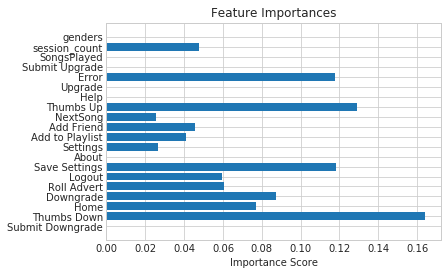

In [24]:
best_model = cvModel_gbt
importance = list(best_model.bestModel.featureImportances.toArray())
len(importance), len(feature_cols)
y_pos = np.arange(len(feature_cols))
 
plt.barh(y_pos, importance, align='center')
plt.yticks(y_pos, feature_cols)
plt.xlabel('Importance Score')
plt.title('Feature Importances');

In [26]:
feature_cols

['Submit Downgrade',
 'Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'About',
 'Settings',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade',
 'SongsPlayed',
 'session_count',
 'genders']

## Conclusion
# Summary
We developed a model which can predict customer churn. We performed EDA, Feature engineering and created featureset to be used for ML model trainig and validation. We used cross validation and grid search to fine tune our model. However we achieved about 87% accuracy, and 0.84 F1 score with base Random Forest model.

# Reflection
This project gives exposure to spark environment to analyze a large volume of data.

One of the interesting things was to identify the derived features from the page column. This will be  a key takeaway from this project.Exposure to spark to handle big data is another big plus

# Improvement
There is still lot of scope for improvement here. We have not taken into account some features like user_agent and location which can play a part here.
Also I was not able to run this on cloud spark cluster due to time constraints and few platform config issues.

Next step will be to develop the model on large data on aws cluster.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.